In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
import numpy as np
import pandas as pd
import os, shutil, glob, sys, math, cv2, re

import segmentation_models_pytorch as smp
import albumentations as albu
from torchsummary import summary

from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from torch import Tensor
from torch.jit.annotations import List
from torchvision import models

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

from sklearn.model_selection import train_test_split

In [3]:
ROOT_FOLDER = "/home/Tsung/pathology/"
DATA_FOLDER = "/home/Tsung/pathology/data/tcga/"

# model

In [4]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=9, bias=True)
model.load_state_dict(torch.load('/home/Tsung/pathology/weight/2020_09_23_13_59_zenodo_loss:ce_bs_32_epoch46_acc_0.9981.h5'))
model.to('cuda:0')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# data

In [5]:
def get_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
#         albu.Resize(height = 224, width = 224, always_apply=True),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

# https://github.com/pytorch/vision/blob/master/torchvision/transforms/functional.py, to_tensor     
def to0_1(x, **kwargs):
    return x/255

def get_preprocessing():

    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
        albu.Lambda(image=to0_1, mask=to0_1),
    ]
    return albu.Compose(_transform)

In [6]:
from PIL import Image

class Dataset(BaseDataset):
    
    def __init__(self, image_array, augmentation=None, preprocessing=None):
        self.image_array = image_array
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        fp = self.image_array[i]
        image = Image.open(fp)
        image = np.asarray(image)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        
        return fp, image
    
    def __len__(self):
        return len(self.image_array)

In [9]:
patches_folders = os.path.join(DATA_FOLDER, '1000dense200')
all_folders = sorted(os.listdir(patches_folders))

In [10]:
for number, folder_name in enumerate(all_folders):
    if folder_name[:5] == "BREAK":
        continue
    all_images = sorted(glob.glob(os.path.join(patches_folders, folder_name, "*.jpg")))
    
    test_dataset = Dataset(
        all_images,
        augmentation = get_augmentation(),
        preprocessing = get_preprocessing()
    )
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    is_stroma_image_name = np.array([])
    is_stroma_pred = np.array([])
    for data in test_dataloader:
        image_names, images = data
        image_names = np.array([name for name in image_names])
        
        images = images.cuda()
        
        with torch.no_grad():
            pred = model(images)
        pred = torch.softmax(pred, axis = 1)
        pred = torch.argmax(pred, axis = 1)
        pred = pred.detach().cpu().numpy()
        
        if len(pred.shape) != 1:
            pred = pred.squeeze()
            
#         tp = np.where(pred == 1)[0]
#         is_stroma_image_name = np.concatenate((is_stroma_image_name, image_names[tp]))
        is_stroma_pred = np.concatenate((is_stroma_pred, pred))
    print("{}, all_images: {}, tumor_images: {}".format(number, len(all_images), len(is_stroma_image_name)))
    break
#     np.save("/home/Tsung/pathology/data/tumor/{}.npy".format(folder_name), is_stroma_image_name)


0, all_images: 200, tumor_images: 0


In [16]:
folder_name

'TCGA-3L-AA1B-01A-01-TS1.9C415218-D5B4-4945-B243-F42A4C8C0484.svs'

In [11]:
len(is_stroma_pred)

200

In [12]:
for i in range(9):
    print(np.count_nonzero(is_stroma_pred == i))

3
61
0
0
0
0
0
136
0


In [13]:
all_images = np.array(all_images)

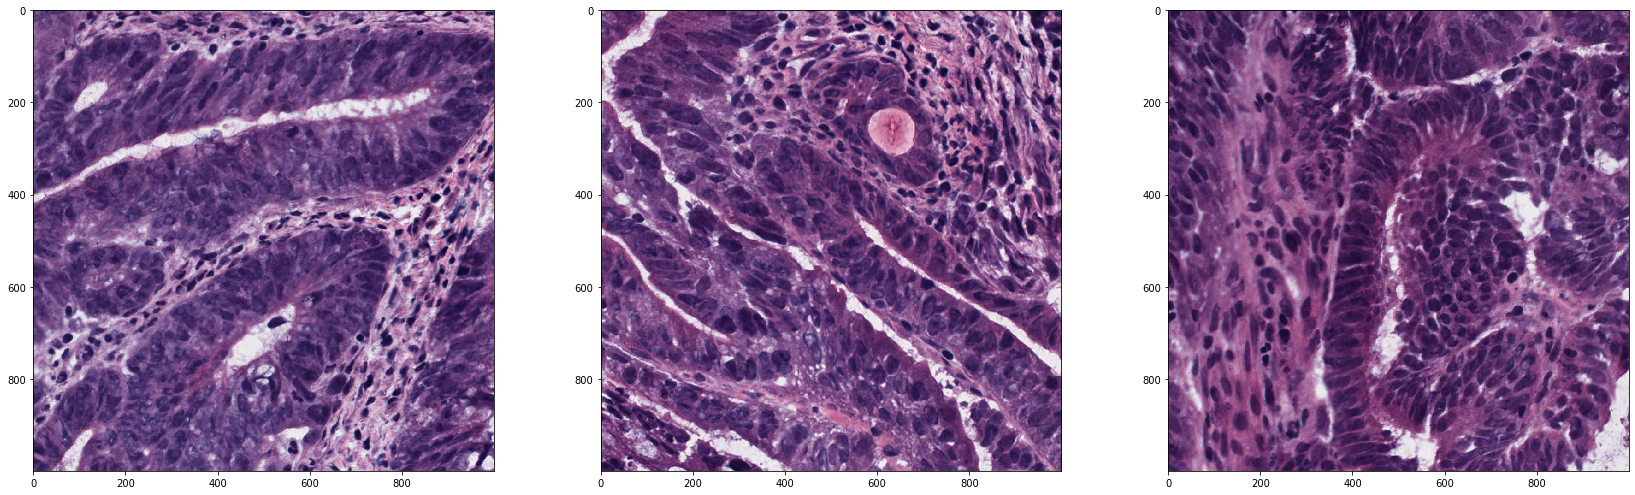

In [17]:
BACK = np.where(is_stroma_pred == 0)[0]
nrow = 10
ncol = 10
plt.figure(figsize=(100,100))

for idx, name in enumerate(all_images[BACK]):
    image = Image.open(name)
    image = np.asarray(image)
    
    plt.subplot(nrow, ncol, idx+1)
    plt.imshow(image)
    if idx+1 == 99:
        break